# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_path = "/content/drive/MyDrive/Testing Hackathon"

In [3]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 27.2 MB/s 
     |████████████████████████████████| 132 kB 97.9 MB/s 
     |████████████████████████████████| 182 kB 72.6 MB/s 
     |████████████████████████████████| 212 kB 82.5 MB/s 
     |████████████████████████████████| 127 kB 93.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.1 MB/s 
     |████████████████████████████████| 7.6 MB 65.8 MB/s 


In [4]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
from pprint import pprint

In [6]:
from datasets import load_dataset

# ['wikitext-103-v1', 'wikitext-2-v1', 'wikitext-103-raw-v1', 'wikitext-2-raw-v1']

dataset = load_dataset("wikitext", 'wikitext-2-v1')

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [8]:
train_set = dataset["train"]
val_set = dataset["validation"]
test_set = dataset["test"]

In [9]:
def generate_checkpoints():
  checkpoints = []
  start_stop_steps = [(0, 100, 10), (100, 2000, 50), (2000, 20000, 100), (20000, 401000, 1000)]
  for start, stop, step in start_stop_steps:
    for num in range(start, stop, step):
      checkpoints.append(num)
  return checkpoints

checkpoint_numbers = generate_checkpoints()

In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("stanford-crfm/battlestar-gpt2-small-x49")

base_model = AutoModelForCausalLM.from_pretrained("stanford-crfm/battlestar-gpt2-small-x49", revision="main").to(device)

Downloading:   0%|          | 0.00/200 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/948 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

# Processing

In [11]:
def do_tokenize(text):
  token_dict = tokenizer(text["text"])
  token_dict["tokens"] = [token.replace("Ġ", " ") for token in tokenizer.convert_ids_to_tokens(token_dict["input_ids"])]
  return token_dict

In [12]:
tokenized_train = train_set.map(do_tokenize)

  0%|          | 0/36718 [00:00<?, ?ex/s]

In [13]:
print(tokenized_train[0])

{'text': '', 'input_ids': [], 'attention_mask': [], 'tokens': []}


In [14]:
from torch.nn import CrossEntropyLoss
import torch

def get_token_losses(model, data, n=1000, device="cuda:0"):
  enriched = []
  for i, batch in enumerate(data):
    if i >= n:
      break
    # print(batch)
    if not batch["text"]:
      continue
    # TODO fix this - 0 is the index of !, not <|endoftext|>. Shouldn't matter too much
    input_ids = torch.tensor(batch["input_ids"] + [0]).to(device)
    # inputs = [torch.tensor(example["input_ids"]) for example in batch]
    # batch = torch.stack(inputs).to(device)
    outputs = model(input_ids)
    lm_logits = outputs.logits
    labels = input_ids

    # From https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py#L1070
    shift_logits = lm_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    # Flatten the tokens
    loss_fct = CrossEntropyLoss(reduction='none')
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    batch["loss"] = [token_loss.item() for token_loss in loss.cpu().detach()]
    batch.pop("attention_mask")
    # print(input_ids.shape)
    enriched.append(batch)
  return enriched

In [ ]:
%%time

enriched_data = get_token_losses(base_model, tokenized_train, n=5000)

CPU times: user 49.9 s, sys: 1.07 ms, total: 49.9 s
Wall time: 50.1 s


In [ ]:
print(enriched_data[0])

{'text': ' = Valkyria Chronicles III = \n', 'input_ids': [796, 569, 18354, 7496, 17740, 6711, 796, 220, 198], 'tokens': [' =', ' V', 'alky', 'ria', ' Chronicles', ' III', ' =', ' ', 'Ċ'], 'loss': [tensor(8.4425), tensor(9.6367), tensor(0.1484), tensor(0.2648), tensor(4.1983), tensor(8.5901), tensor(7.1592), tensor(10.6149), tensor(17.4040)]}


In [ ]:
# Failed from 377000

In [15]:
%%time
import json

for i, checkpoint in enumerate(checkpoint_numbers):
  if checkpoint < 377000:
    continue
  print(f"{i} complete")
  try:
    model = AutoModelForCausalLM.from_pretrained("stanford-crfm/battlestar-gpt2-small-x49", revision=f"checkpoint-{checkpoint}").to(device)
    enriched_data = get_token_losses(model, tokenized_train, n=5000)
    with open(f"{base_path}/Data/{checkpoint}.json", "w") as ofh:
      json.dump(enriched_data, ofh)
  except:
    print(f"{checkpoint} failed")

585 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

586 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

587 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

588 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

589 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

590 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

591 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

592 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

593 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

594 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

595 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

596 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

597 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

598 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

599 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

600 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

601 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

602 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

603 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

604 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

605 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

606 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

607 complete


Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

608 complete
CPU times: user 21min 34s, sys: 16.3 s, total: 21min 51s
Wall time: 26min 41s


# Analysis

In [11]:
import math

def batch(arr, n=None, batch_size=None):
    if n is None and batch_size is None:
        raise ValueError("Either n or batch_size must be provided")
    if n is not None and batch_size is not None:
        raise ValueError("Either n or batch_size must be provided, not both")
    
    if n is not None:        
        batch_size = math.floor(len(arr) / n)
    elif batch_size is not None:
        n = math.ceil(len(arr) / batch_size)
        
    extras = len(arr) - (batch_size * n)
    groups = []
    group = []
    added_extra = False
    for element in arr:
        group.append(element)
        if len(group) >= batch_size:
            if extras and not added_extra:
                extras -= 1
                added_extra = True
                continue                
            groups.append(group)
            group = []
            added_extra = False

    if group:
      groups.append(group)

    return groups

In [13]:
import json
import os
import numpy as np

def process(func_1, func_2, paths):
  avgs = []
  for i, path in enumerate(paths):      
    try:
      with open(path) as ifh:
        data = json.load(ifh)
    except:
      pass

    sum_1 = 0
    sum_2 = 0
    count_1 = 0
    count_2 = 0

    for j, row in enumerate(data):
      for k, token_loss in enumerate(row["loss"]):
        include_1 = func_1(row, k)
        include_2 = func_2(row, k)

        sum_1 += include_1 * token_loss
        sum_2 += include_2 * token_loss

        count_1 += include_1
        count_2 += include_2

    avgs.append((path, sum_1 / count_1, sum_2 / count_2))

  return avgs

In [14]:
paths = [f"{base_path}/Data/{checkpoint}.json" for checkpoint in checkpoint_numbers]

In [15]:
def path_to_checkpoint(path):
  return int(path.split("/")[-1].replace(".json", ""))

In [74]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from functools import partial

def plot(results, titles=None, smoothing=3):
  losses_1 = [loss for _, loss, _ in results]
  losses_2 = [loss for _, _, loss in results]
  losses_diff = [loss_2 - loss_1 for loss_1, loss_2 in zip(losses_1, losses_2)]

  checkpoints = [path_to_checkpoint(path) for path, _, _ in results]

  if titles is None:
    titles = ["Func 1", "Func 2"]

  plt.figure(figsize=[15, 5])
  
  for x, y, title in zip([checkpoints, checkpoints], [losses_1, losses_2], titles):
    if smoothing is not None:
      y = gaussian_filter1d(y, sigma=smoothing)

    plt.plot(x, y)

  plt.xlabel("Training Steps")
  plt.ylabel("Loss")
  plt.legend(titles)   

  plt.figure(figsize=[15, 5])
  x = checkpoints
  y = losses_diff
  if smoothing is not None:
    y = gaussian_filter1d(y, sigma=smoothing)
  plt.plot(x, y)
  plt.title(f"Diff: ('{titles[1]}' - '{titles[0]})'")
  plt.xlabel("Training Steps")
  plt.ylabel("Difference in Loss")

    # x_trunc = [checkpoint for checkpoint in x if checkpoint <= 50000]
    # y_trunc = y[:len(x_trunc)]

    # plt.figure(figsize=[15, 5])
    # # plt.xscale("log")
    # plt.plot(x_trunc, y_trunc)
    # plt.xlabel("Training Steps")
    # plt.ylabel("Loss")
    # plt.title(title)    

In [17]:
import multiprocessing as mp

def run(func_1, func_2, paths=paths, titles=None, smoothing=3):
  group_num = 10
  grouped_paths = batch(paths, n=group_num)

  with mp.Pool(group_num) as p:
      all_results = p.map(partial(process, func_1, func_2), grouped_paths)

  results = list(sorted([entry for part_results in all_results for entry in part_results], key=lambda x: path_to_checkpoint(x[0])))

  plot(results, titles=titles, smoothing=smoothing)

  return results

In [18]:
import re

def token_match(func, row, index):
  token = row["tokens"][index]
  return func(token) is not None

def inverse(func, row, index):
  return not func(row, index)

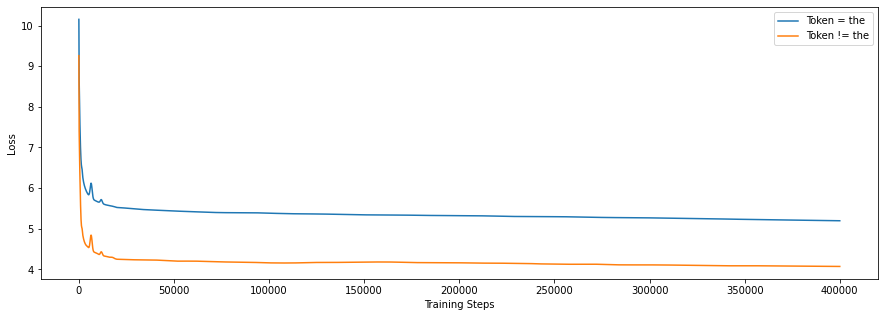

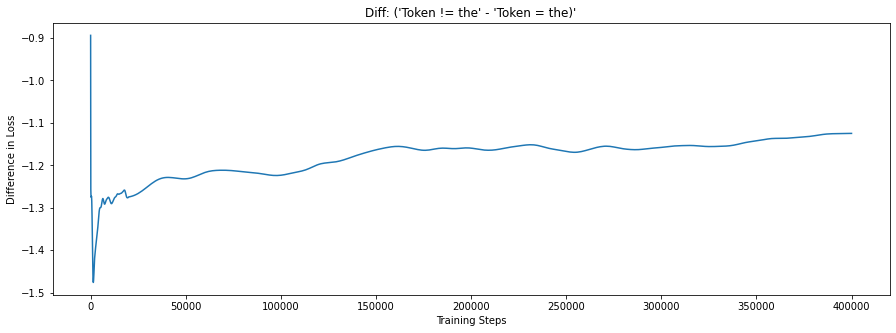

In [75]:
the_match = partial(token_match, re.compile(r"\b[Tt][Hh][Ee]\b").search)
not_the_match = partial(inverse, the_match)
the_results = run(the_match, not_the_match, titles=["Token = the", "Token != the"])

/content/drive/MyDrive/Testing Hackathon/Data/375000.json failed
/content/drive/MyDrive/Testing Hackathon/Data/376000.json failed
/content/drive/MyDrive/Testing Hackathon/Data/274000.json failed


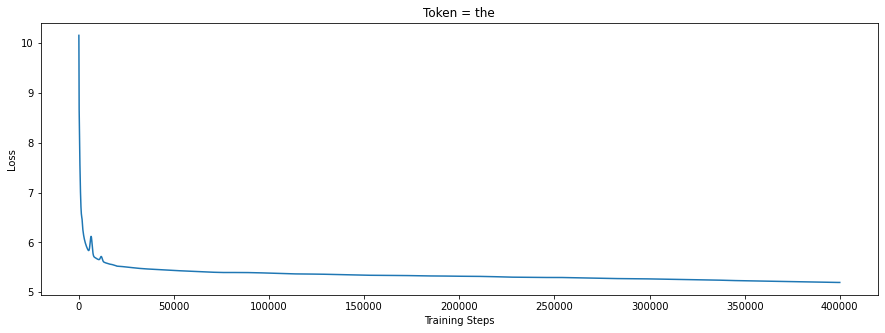

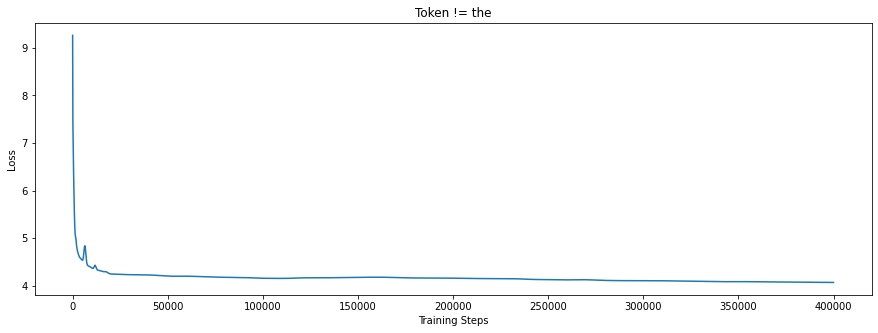

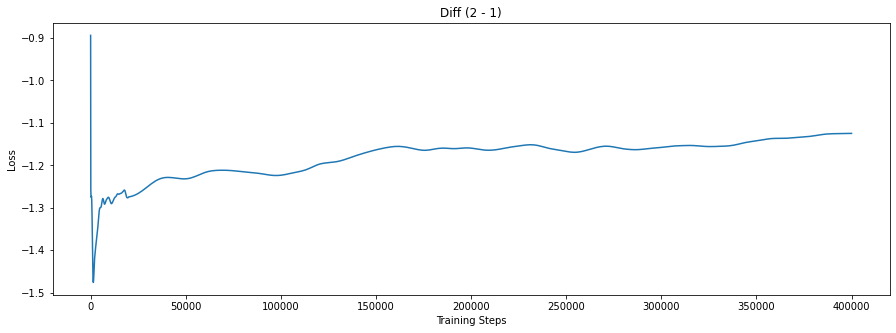

In [135]:
the_match = partial(token_match, re.compile(r"\b[Tt][Hh][Ee]\b").search)
not_the_match = partial(inverse, the_match)
the_results = run(the_match, not_the_match, titles=["Token = the", "Token != the"])

/content/drive/MyDrive/Testing Hackathon/Data/375000.json failed
/content/drive/MyDrive/Testing Hackathon/Data/376000.json failed
/content/drive/MyDrive/Testing Hackathon/Data/274000.json failed


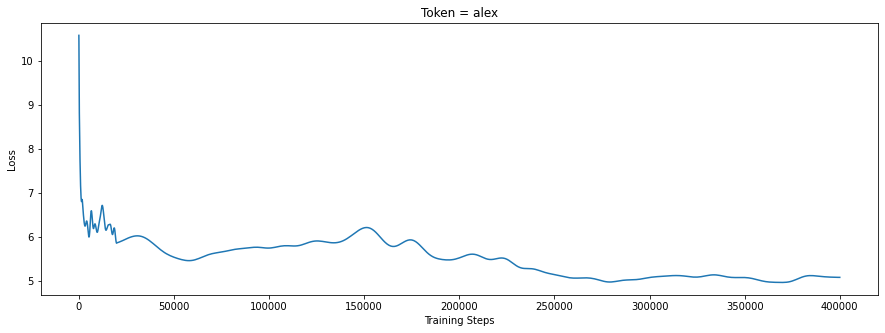

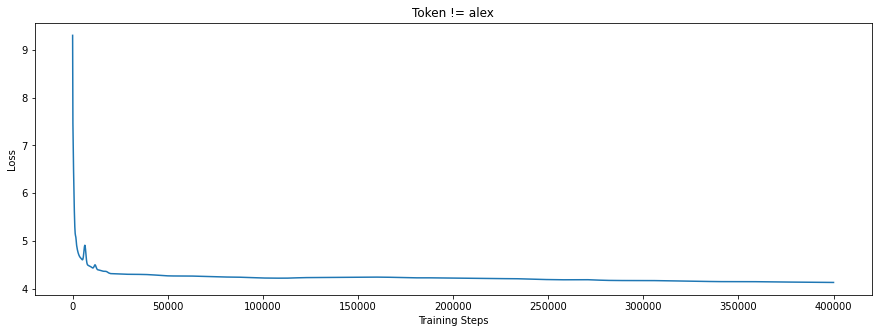

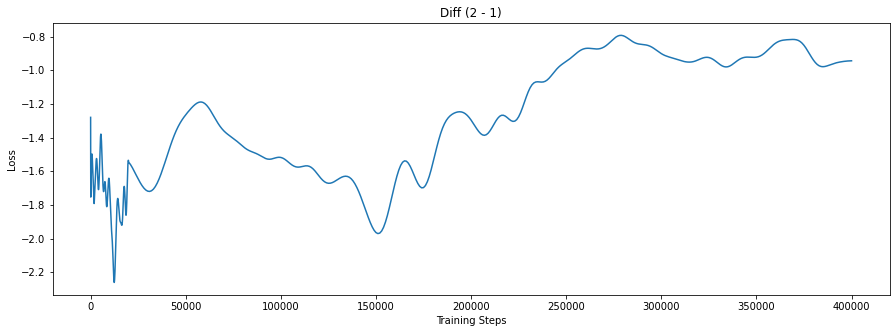

In [136]:
alex_match = partial(token_match, re.compile(r"\b[Aa][Ll][Ee][Xx]\b").search)
not_alex_match = partial(inverse, alex_match)
alex_results = run(alex_match, not_alex_match, titles=["Token = alex", "Token != alex"])

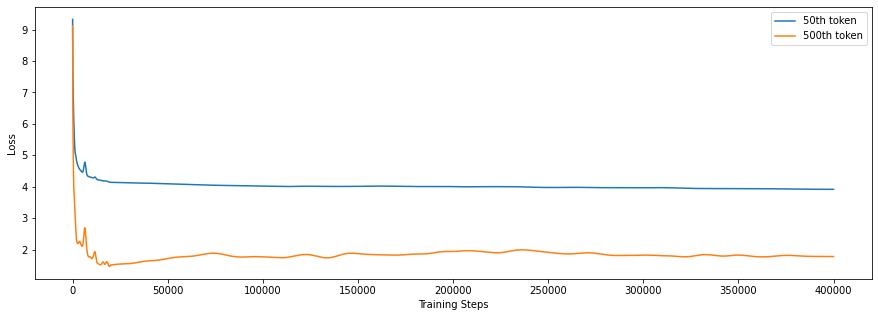

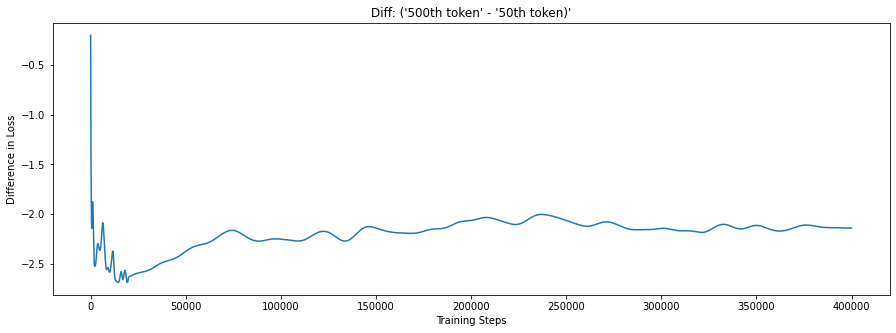

In [76]:
def position(position, row, index):
  return index == position

index_500 = partial(position, 500)
index_50 = partial(position, 50)
in_context_results = run(index_50, index_500, titles=["50th token", "500th token"])

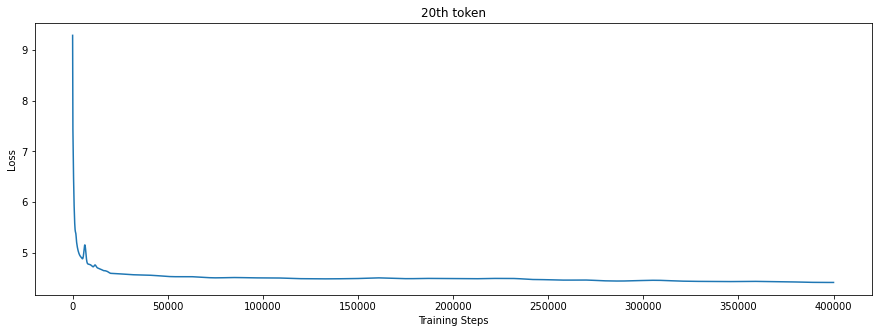

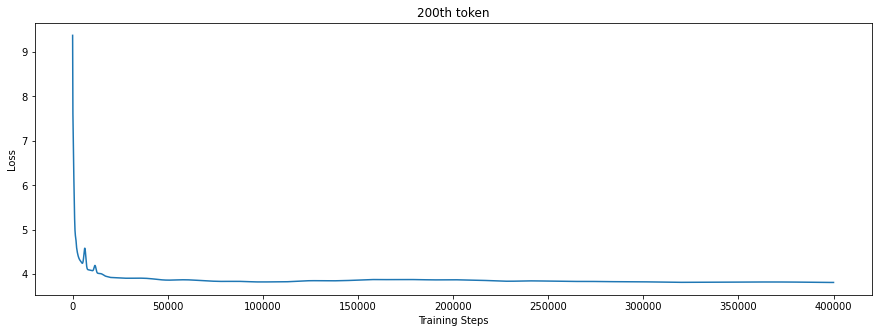

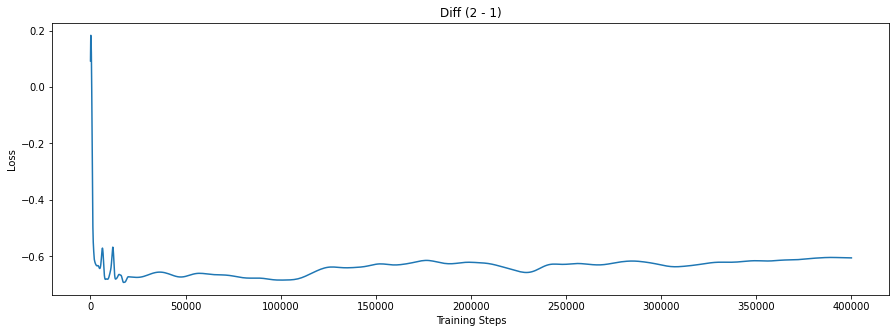

In [178]:
index_200 = partial(position, 200)
index_20 = partial(position, 20)
in_context_20_200_results = run(index_20, index_200, titles=["20th token", "200th token"])

/content/drive/MyDrive/Testing Hackathon/Data/375000.json failed
/content/drive/MyDrive/Testing Hackathon/Data/376000.json failed
/content/drive/MyDrive/Testing Hackathon/Data/274000.json failed


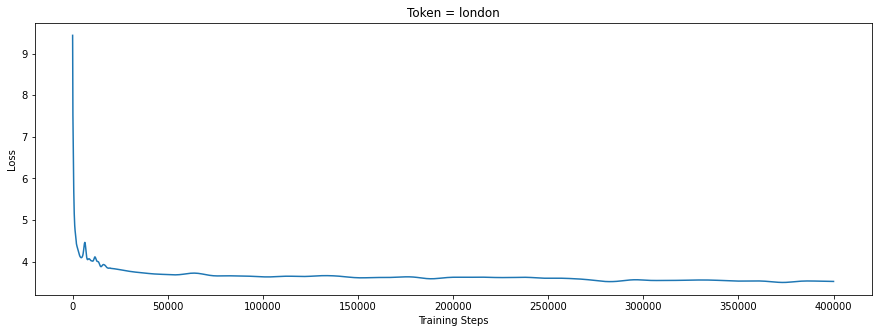

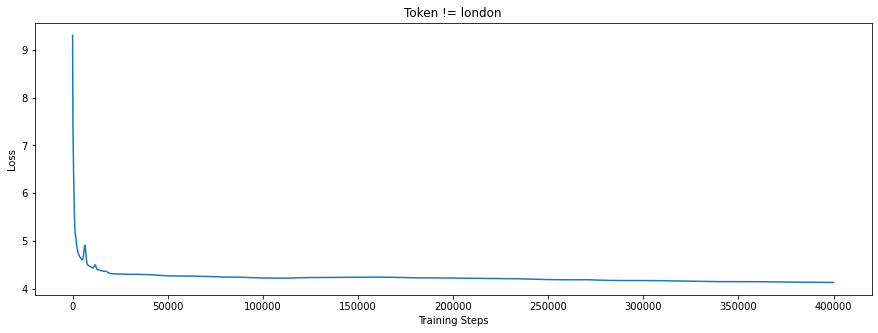

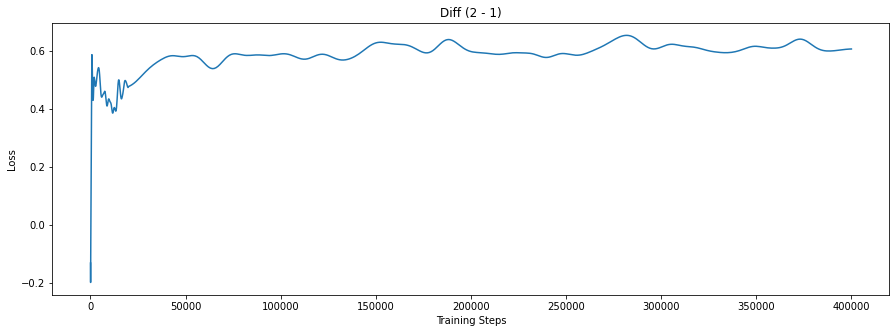

In [145]:
london_match = partial(token_match, re.compile(r"\b[Ll]ondon\b").search)
not_london_match = partial(inverse, london_match)
london_results = run(london_match, not_london_match, titles=["Token = london", "Token != london"])

In [85]:
from collections import Counter

with open(f"{base_path}/Data/0.json") as ifh:
  data_0 = json.load(ifh)

token_freqs = Counter()
count = 0
for row in data_0: 
  token_freqs.update(row["tokens"])
  count += len(row["tokens"])
token_proportions = Counter({token: freq / count for token, freq in token_freqs.items()})

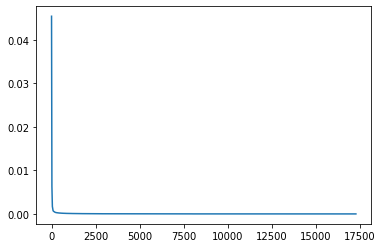

In [153]:
plt.plot([i for i, _ in enumerate(token_proportions)], [prop for _, prop in token_proportions.most_common()])

In [86]:
pprint(token_proportions.most_common(100))

[(' the', 0.0454066262704627),
 (' ,', 0.04280391782698871),
 (' .', 0.030084431611645868),
 (' of', 0.02379976663215158),
 ('unk', 0.02319288509605308),
 (' <', 0.02318662858537165),
 ('>', 0.02318350033003094),
 (' and', 0.02082792405847335),
 (' in', 0.016551599007717407),
 (' to', 0.015462966149148959),
 (' a', 0.014289870396381235),
 (' =', 0.012976003153281384),
 (' "', 0.011796650889832231),
 (' @', 0.010510937944798807),
 ('@', 0.010510937944798807),
 (' ', 0.010135547303913134),
 ('Ċ', 0.010094879984483853),
 (' was', 0.008264850610166205),
 ('-', 0.007692379882815555),
 (' The', 0.006997907197177062),
 (" '", 0.006925957324340642),
 ('s', 0.006328460554264281),
 (' that', 0.006100097914392164),
 (' for', 0.0058154266783871965),
 (' as', 0.005730963784187921),
 (' with', 0.005730963784187921),
 (' on', 0.005465062080227237),
 (' is', 0.005208545142288694),
 (' by', 0.004858180544128734),
 (' )', 0.004611048372212333),
 (' (', 0.00460792011687162),
 ('.', 0.003644417471931729),

In [87]:
def token_proportion(threshold, direction, row, index):
  token = row["tokens"][index]
  proportion = token_proportions.get(token, 0)
  return proportion > threshold if direction == "above" else proportion < threshold

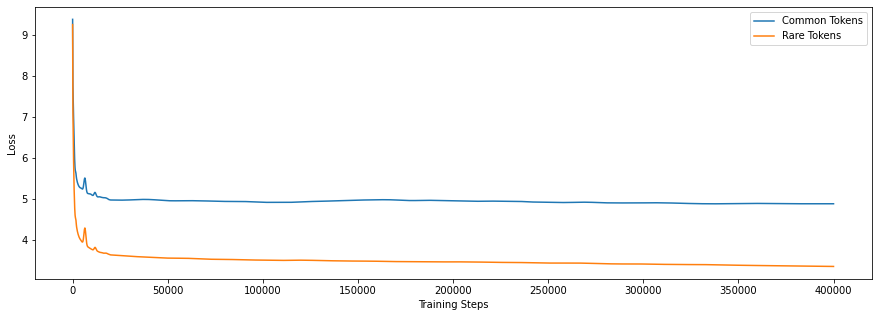

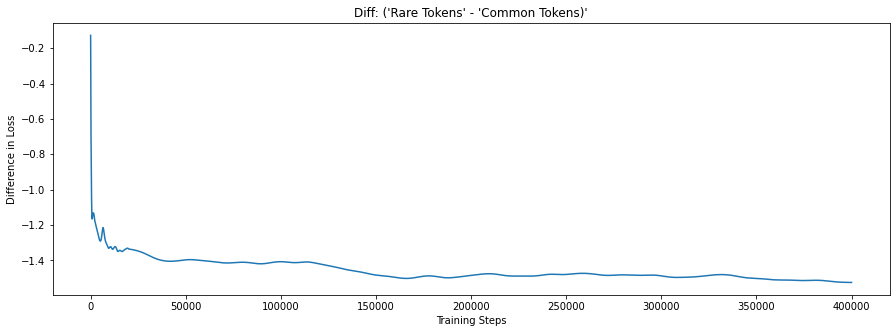

In [88]:
common = partial(token_proportion, 0.001, "above")
rare = partial(token_proportion, 0.001, "below")
commonality_results = run(common, rare, titles=["Common Tokens", "Rare Tokens"])

/content/drive/MyDrive/Testing Hackathon/Data/375000.json failed
/content/drive/MyDrive/Testing Hackathon/Data/376000.json failed
/content/drive/MyDrive/Testing Hackathon/Data/274000.json failed


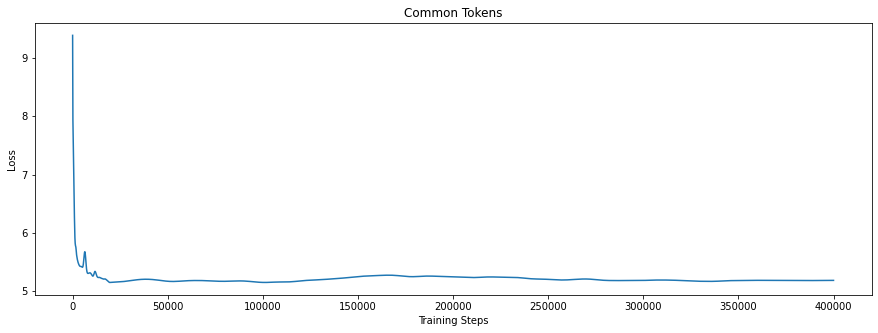

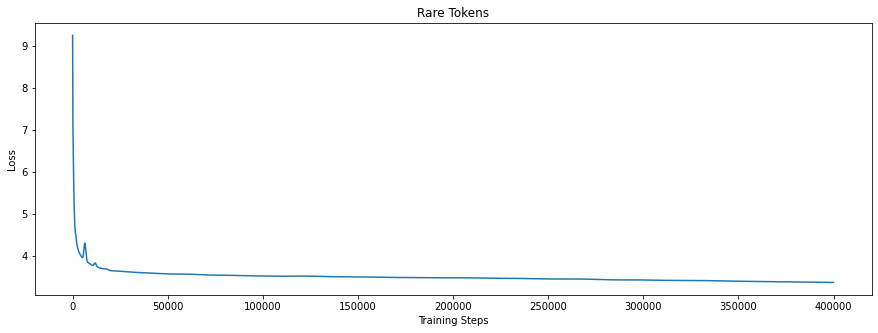

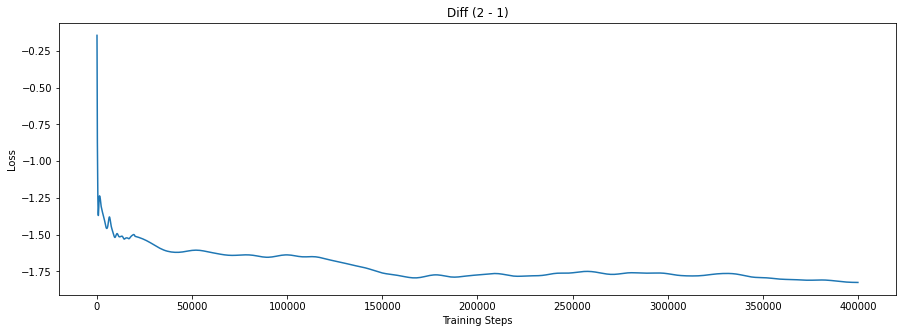

In [163]:
common = partial(token_proportion, 0.001, "above")
rare = partial(token_proportion, 0.001, "below")
commonality_results = run(common, rare, titles=["Common Tokens", "Rare Tokens"])

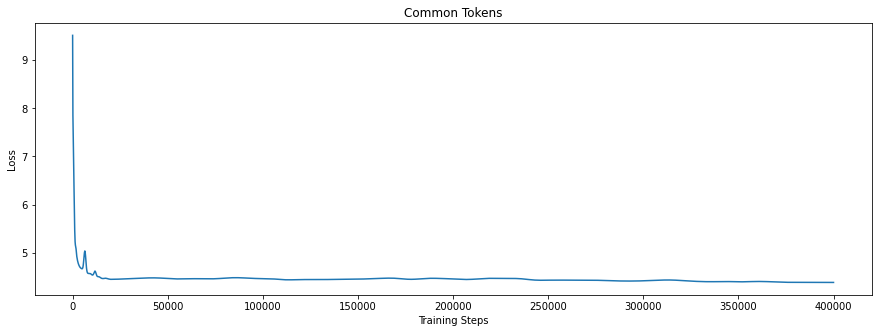

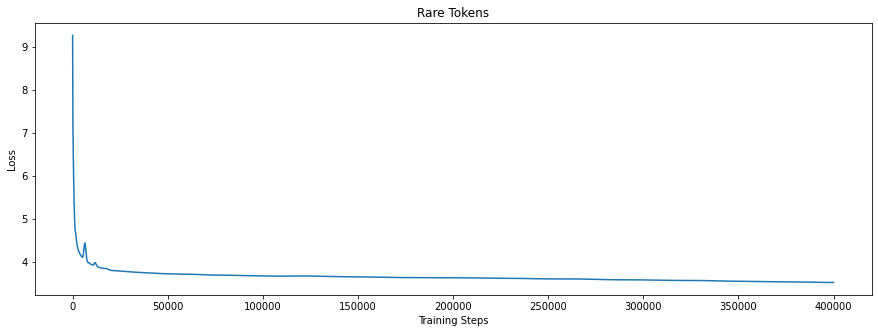

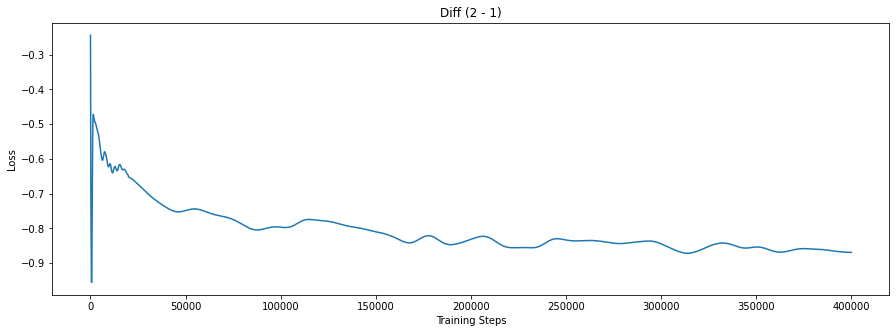

In [185]:
common = partial(token_proportion, 0.02, "above")
rare = partial(token_proportion, 0.005, "below")
commonality_results_2 = run(common, rare, titles=["Common Tokens", "Rare Tokens"])

/content/drive/MyDrive/Testing Hackathon/Data/375000.json failed
/content/drive/MyDrive/Testing Hackathon/Data/376000.json failed
/content/drive/MyDrive/Testing Hackathon/Data/274000.json failed


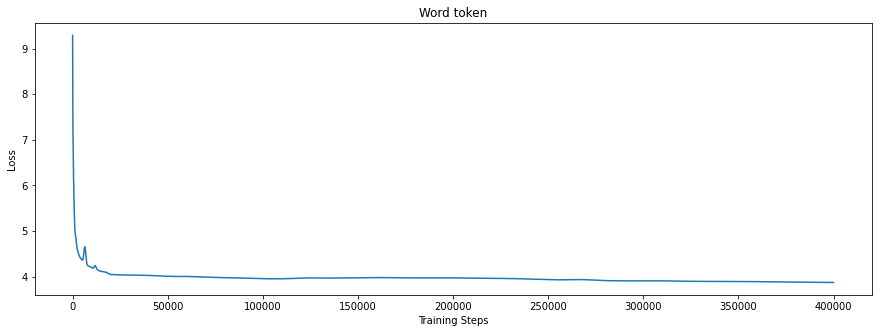

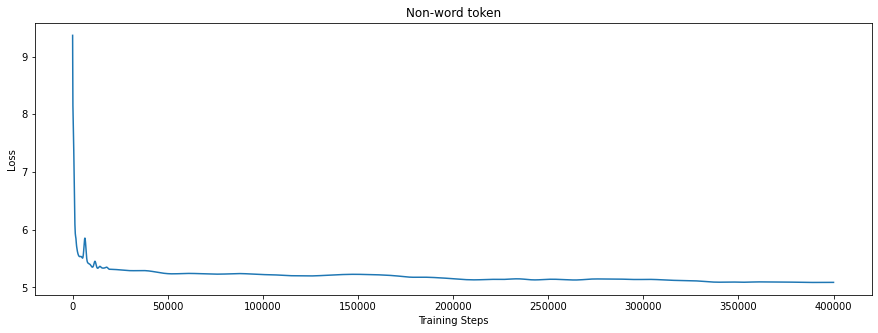

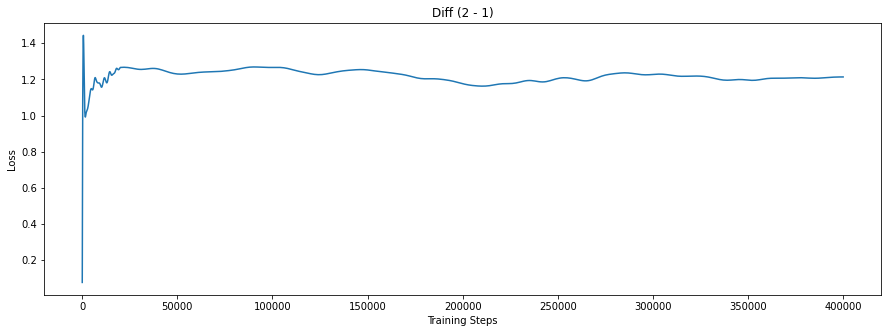

In [164]:
word_match = partial(token_match, re.compile(r"\b\w{1,50}\b").search)
non_word_match = partial(inverse, word_match)
word_vs_non_word_results = run(word_match, non_word_match, titles=["Word token", "Non-word token"])

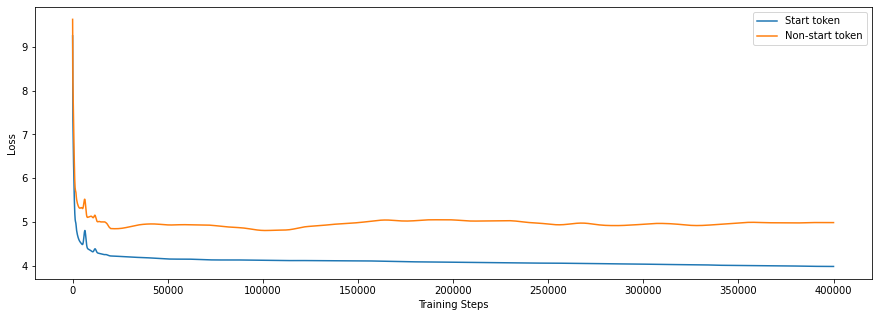

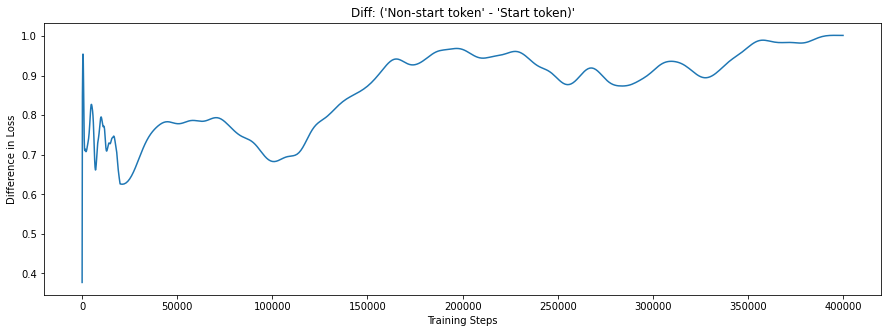

In [94]:
start_match = partial(token_match, re.compile(r"^ ").search)
non_start_match = partial(inverse, start_match)
start_vs_non_start_results = run(start_match, non_start_match, titles=["Start token", "Non-start token"])

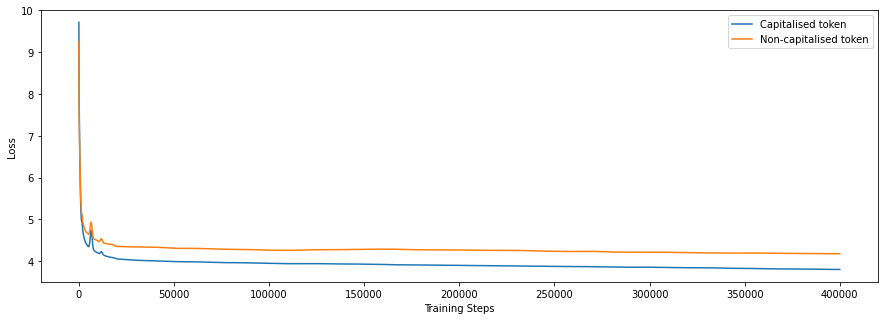

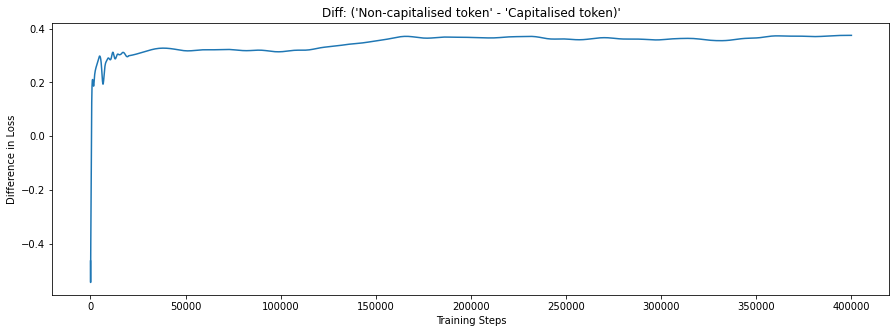

In [91]:
capital_match = partial(token_match, re.compile(r"^ [A-Z]").search)
non_capital_match = partial(inverse, capital_match)
capital_vs_non_capital_results = run(capital_match, non_capital_match, titles=["Capitalised token", "Non-capitalised token"])

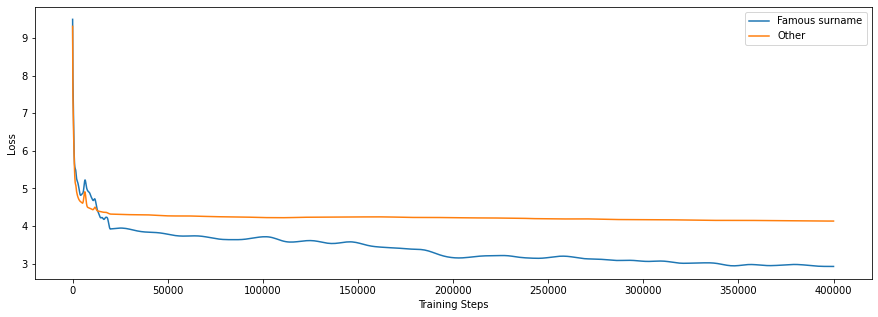

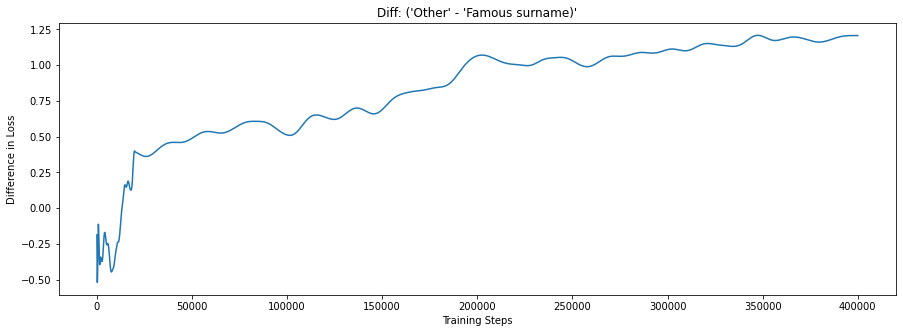

In [77]:
surnames = ["Obama", "Trump", "Biden", "Clinton", "Bush", "Reagan"]
famous_match = partial(token_match, re.compile(("|".join(surnames))).search)
non_famous_match = partial(inverse, famous_match)
famous_vs_non_famous_results = run(famous_match, non_famous_match, titles=["Famous surname", "Other"])

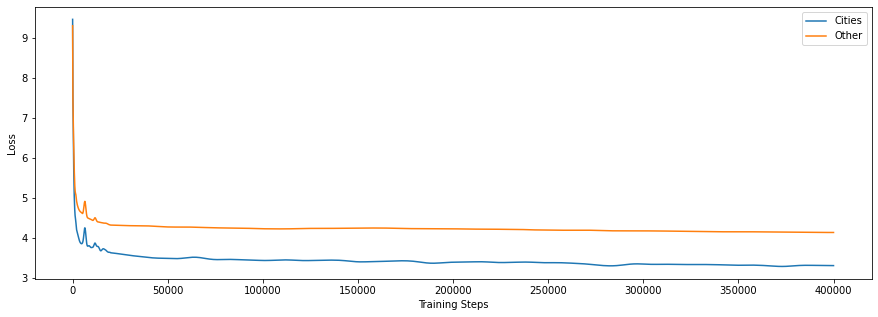

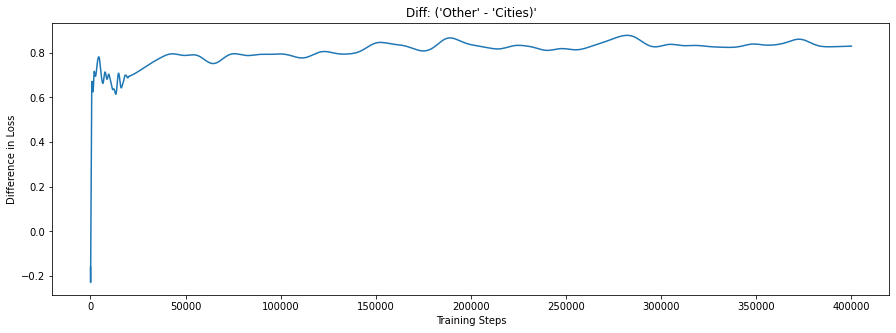

In [78]:
cities = ["London", "Paris", "Berlin", "Tokyo", "Beijing", "Madrid", "Lisbon", "Copenhagen"]
cities_match = partial(token_match, re.compile(("|".join(cities))).search)
non_cities_match = partial(inverse, cities_match)
cities_vs_non_cities_results = run(cities_match, non_cities_match, titles=["Cities", "Other"])

In [81]:
#@title
stopword_str = """
i
me
my
myself
we
our
ours
ourselves
you
your
yours
yourself
yourselves
he
him
his
himself
she
her
hers
herself
it
its
itself
they
them
their
theirs
themselves
what
which
who
whom
this
that
these
those
am
is
are
was
were
be
been
being
have
has
had
having
do
does
did
doing
a
an
the
and
but
if
or
because
as
until
while
of
at
by
for
with
about
against
between
into
through
during
before
after
above
below
to
from
up
down
in
out
on
off
over
under
again
further
then
once
here
there
when
where
why
how
all
any
both
each
few
more
most
other
some
such
no
nor
not
only
own
same
so
than
too
very
s
t
can
will
just
don
should
now
"""
stopwords = [" " + word for word in stopword_str.split("\n") if word]

In [82]:
print(stopwords)

[' i', ' me', ' my', ' myself', ' we', ' our', ' ours', ' ourselves', ' you', ' your', ' yours', ' yourself', ' yourselves', ' he', ' him', ' his', ' himself', ' she', ' her', ' hers', ' herself', ' it', ' its', ' itself', ' they', ' them', ' their', ' theirs', ' themselves', ' what', ' which', ' who', ' whom', ' this', ' that', ' these', ' those', ' am', ' is', ' are', ' was', ' were', ' be', ' been', ' being', ' have', ' has', ' had', ' having', ' do', ' does', ' did', ' doing', ' a', ' an', ' the', ' and', ' but', ' if', ' or', ' because', ' as', ' until', ' while', ' of', ' at', ' by', ' for', ' with', ' about', ' against', ' between', ' into', ' through', ' during', ' before', ' after', ' above', ' below', ' to', ' from', ' up', ' down', ' in', ' out', ' on', ' off', ' over', ' under', ' again', ' further', ' then', ' once', ' here', ' there', ' when', ' where', ' why', ' how', ' all', ' any', ' both', ' each', ' few', ' more', ' most', ' other', ' some', ' such', ' no', ' nor', '

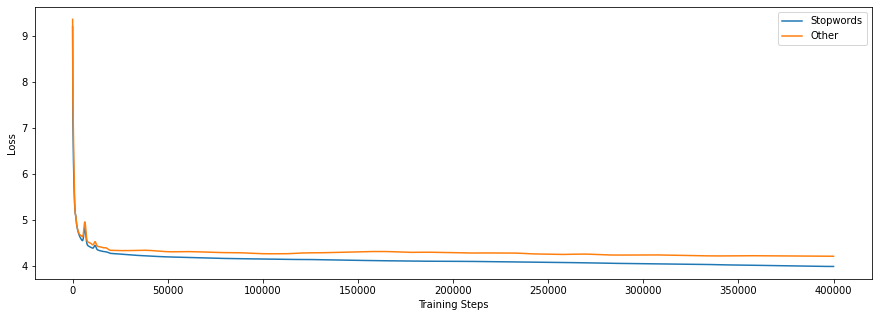

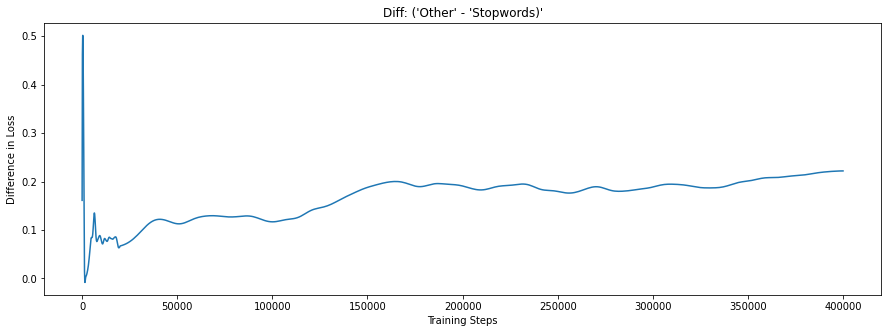

In [83]:
stopwords_match = partial(token_match, re.compile(("|".join(stopwords))).search)
non_stopwords_match = partial(inverse, stopwords_match)
stopwords_vs_non_stopwords_results = run(stopwords_match, non_stopwords_match, titles=["Stopwords", "Other"])

In [89]:
def combine_and(funcs, row, index):
  result = True
  for func in funcs:
    result &= func(row, index)
  return result

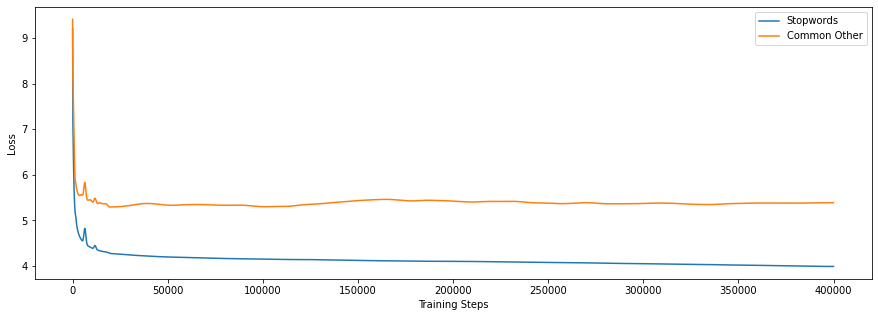

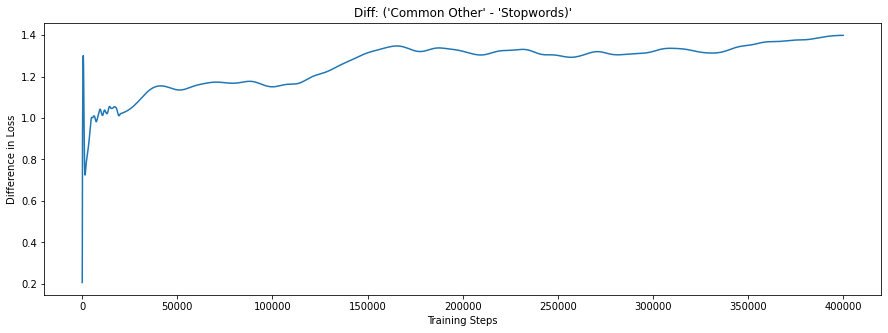

In [90]:
stopwords_match = partial(token_match, re.compile(("|".join(stopwords))).search)

non_stopwords_match = partial(inverse, stopwords_match)
common = partial(token_proportion, 0.001, "above")

non_stopword_and_common = partial(combine_and, [non_stopwords_match, common])
stopwords_vs_common_non_stopwords_results = run(stopwords_match, non_stopword_and_common, titles=["Stopwords", "Common Other"])

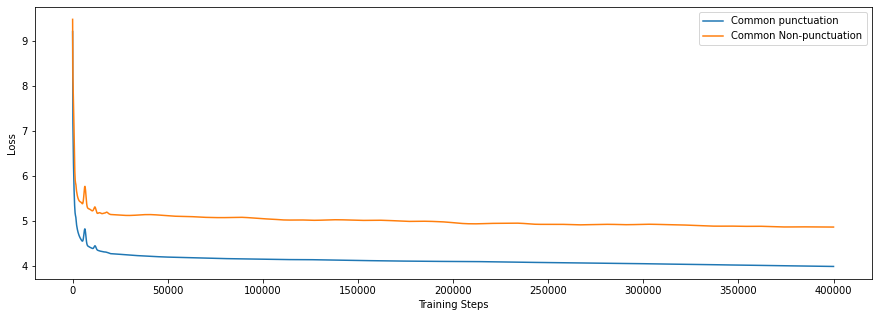

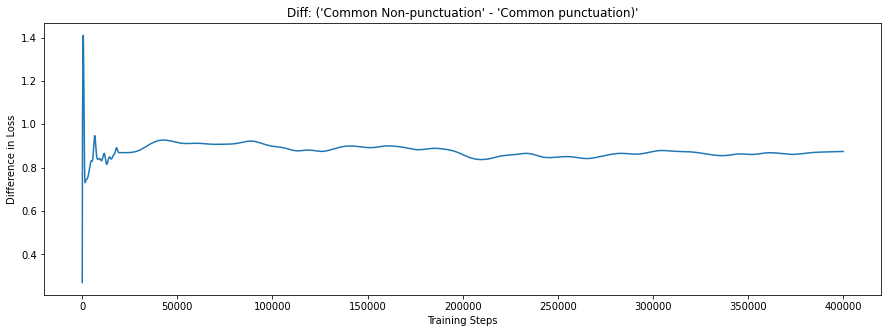

In [93]:
from string import punctuation

punctuation_chars = [re.escape(c) for c in punctuation]

punctuation_match = partial(token_match, re.compile(("|".join(punctuation_chars))).search)
non_punctuation_match = partial(inverse, punctuation_match)

common = partial(token_proportion, 0.001, "above")
punctuation_and_common = partial(combine_and, [punctuation_match, common])
non_punctuation_and_common = partial(combine_and, [non_punctuation_match, common])

punctuation_vs_non_punctuation_results = run(stopwords_match, punctuation_match, titles=["Common punctuation", "Common Non-punctuation"])


In [28]:
checkpoint_to_index = {checkpoint: i for i, checkpoint in enumerate(checkpoint_numbers)}
index_to_checkpoint = {i: checkpoint for i, checkpoint in enumerate(checkpoint_numbers)}

In [31]:
print(checkpoint_to_index[5000])
print(checkpoint_to_index[7500])
print(checkpoint_to_index[6300])

78
103
91


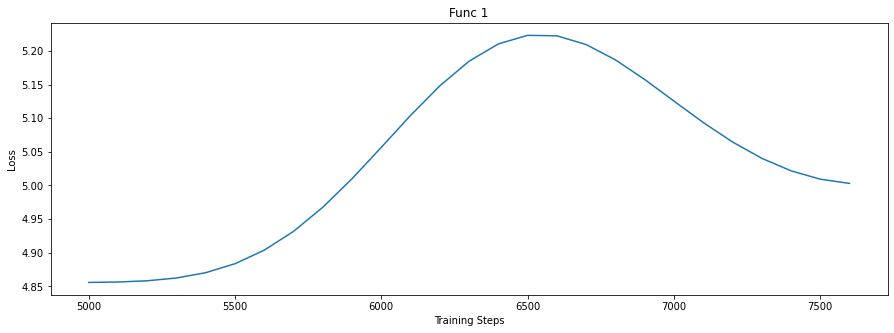

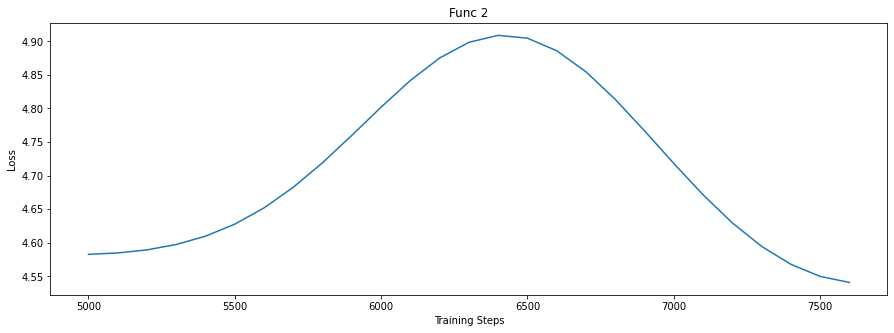

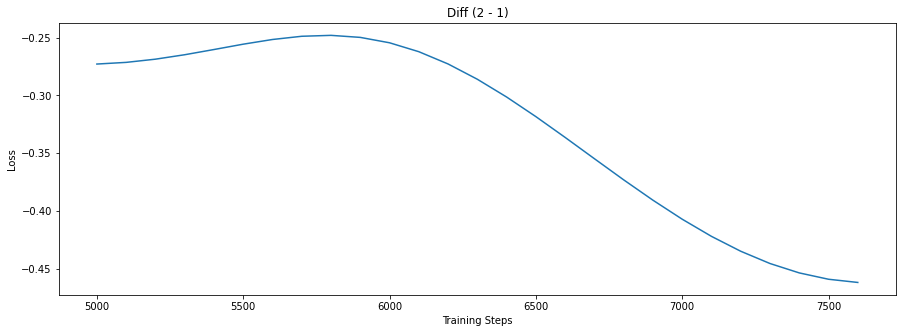

In [27]:
plot(famous_vs_non_famous_results[78:105])

In [95]:
from collections import defaultdict, Counter
import random

def compare_checkpoints(checkpoints, checkpoint_1, checkpoint_2, return_n=5, smoothing=2, seed=0, plot_top=None, plot_bottom=None, plot_random=None):
  token_loss_dicts = []
  started = False
  start = False
  end = False
  token_trajectories = defaultdict(list)
  valid_checkpoints = []
  for i, checkpoint in enumerate(checkpoints):
    if checkpoint_1 <= checkpoint <= checkpoint_2 and not started:      
      started = True
      start = True
      end = False
      print("Start", checkpoint)
    elif started and (i + 1 >= len(checkpoints) or checkpoints[i + 1] > checkpoint_2):
      start = False
      end = True
      print("End", checkpoint)
    elif checkpoint_1 <= checkpoint <= checkpoint_2:
      start = False
      end = False
      # print("Middle", checkpoint)
    else:
      continue

    try:
      with open(f"{base_path}/Data/{checkpoint}.json") as ifh:
        data = json.load(ifh)
    except:
      pass

    valid_checkpoints.append(checkpoint)
    token_stats = defaultdict(list)    

    for entry in data:
      for token, loss in zip(entry["tokens"], entry["loss"]):
        if token == "Ċ":
          token = r"\n"
        token_stats[token].append(loss)

    for token, losses in token_stats.items():
      token_trajectories[token].append(sum(losses) / len(losses))
    
    if start or end:
      token_losses = {token: sum(losses) / len(losses) for token, losses in token_stats.items()}
      token_loss_dicts.append(token_losses)

    if end:
      break
  
  loss_diff = {token: loss_2 - token_loss_dicts[0][token] for token, loss_2 in token_loss_dicts[1].items()}

  plt.figure()
  plt.hist(loss_diff.values(), bins=100)
  plt.grid(visible=True)
  plt.xlabel("Loss")
  plt.ylabel("Frequency")

  loss_diff_counter = Counter(loss_diff)
  ordered_diff = loss_diff_counter.most_common()

  if plot_top is not None:
    top_n = ordered_diff[:plot_top]
  else:
    top_n = []
  if plot_bottom is not None:
    bottom_n = ordered_diff[-plot_bottom:]
  else:
    bottom_n = []
  if plot_random is not None:
    random.seed(seed)
    random_n = random.sample(ordered_diff, plot_random)
  else:
    random_n = []

  plt.figure(figsize=[15, 5])
  legend = []
  for group in [top_n, bottom_n, random_n]:
    for token, avg_loss in group:
      trajectory = token_trajectories[token]
      if smoothing is not None:
        trajectory = gaussian_filter1d(trajectory, sigma=smoothing)
      plt.plot(valid_checkpoints, trajectory)
      legend.append(token)
  plt.legend(legend)

  plt.xlabel("Training Step")
  plt.ylabel("Loss")

  return ordered_diff[:return_n], ordered_diff[-return_n:], random.sample(ordered_diff, return_n)


Start 5500
End 6500
Most Increased
[('asted', 11.979390025138855),
 (' gall', 11.373312830924988),
 ('nar', 10.569373418887457),
 (' Sherman', 10.295616999268532),
 ('end', 9.935823500156403),
 (' Sport', 9.883492946624756),
 ('core', 9.666521448642015),
 (' cardiac', 9.646910548210144),
 (' exce', 9.526932638138533),
 ('wen', 9.04269015789032),
 (' OK', 8.920794486999512),
 ('anse', 8.90138194616884),
 ('lde', 8.89975357055664),
 (' sto', 8.847808718681335),
 (' Past', 8.831618785858154),
 (' angular', 8.808020174503326),
 ('ho', 8.688302159309387),
 (' adop', 8.64641435444355),
 (' poised', 8.440882682800293),
 ('uro', 8.378979921340942),
 ('apping', 8.365197479724884),
 (' harvest', 8.356737613677979),
 ('aceae', 8.32839322090149),
 (' haven', 8.305878430604935),
 (' Tul', 8.30186915397644),
 (' fence', 8.254287719726562),
 (' contacts', 8.248895645141602),
 (' backbone', 8.016748428344727),
 (' Poll', 7.996895015239716),
 (' sil', 7.988450229167938),
 (' Canad', 7.944057941436768),

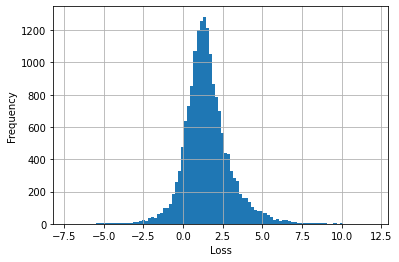

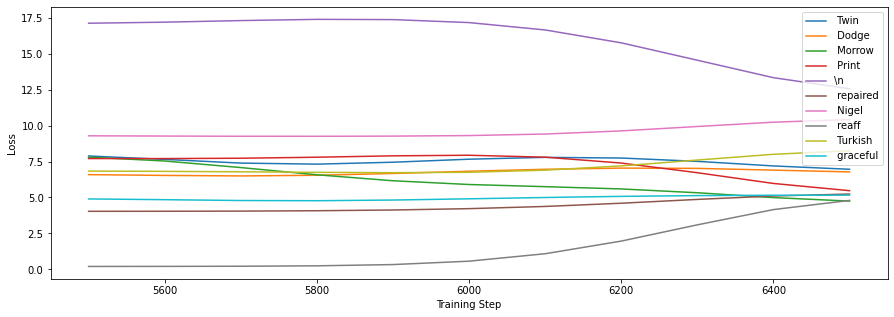

In [96]:
top_n, bottom_n, random_n = compare_checkpoints(checkpoint_numbers, 5500, 6500, plot_bottom=5, plot_random=5, return_n=50)
for name, tokens in zip(["Most Increased", "Most Decreased", "Random"], [top_n, bottom_n, random_n]):
  print(name)
  pprint(tokens)

Start 6500
End 7500
Most Increased
[(' Kirk', 6.481493949890137),
 (' 426', 5.707792282104492),
 ('\\n', 5.333399725063764),
 (' asset', 5.215640068054199),
 (' Bro', 5.168598810831705),
 (' Thirty', 5.099135398864746),
 (' burdens', 4.984781503677368),
 (' Klaus', 4.9159417152404785),
 (' Editor', 4.814628601074219),
 (' shark', 4.672308921813965),
 (' wasn', 4.616047815843062),
 (' ca', 4.581698715686798),
 (' Fisher', 4.298290967941284),
 (' isn', 4.2701049872807095),
 (' accident', 4.176639556884766),
 (' Ultimate', 4.057915449142456),
 (' Abe', 4.029963731765747),
 ('oor', 4.0128374099731445),
 (' Print', 3.8027420043945312),
 (' unexpectedly', 3.7451233863830566),
 (' Wolves', 3.733161449432373),
 (' CNN', 3.6015641689300537),
 (' cursing', 3.594069480895996),
 ('verson', 3.5778098106384277),
 (' Tar', 3.533374786376953),
 (' hydraulic', 3.4796924591064453),
 (' thicker', 3.456057548522949),
 ('bey', 3.4161529541015625),
 (' ultra', 3.3730263710021973),
 (' relegated', 3.34773635

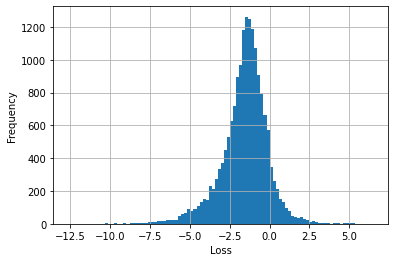

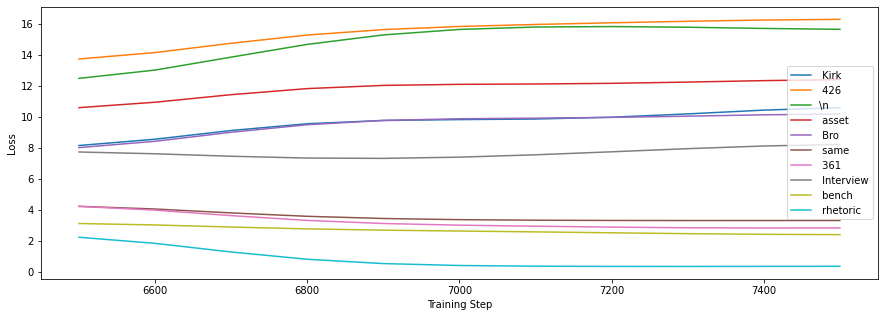

In [97]:
top_n, bottom_n, random_n = compare_checkpoints(checkpoint_numbers, 6500, 7500, plot_top=5, plot_random=5, return_n=50)
for name, tokens in zip(["Most Increased", "Most Decreased", "Random"], [top_n, bottom_n, random_n]):
  print(name)
  pprint(tokens)

Start 0
End 2000
Most Increased
[(' 236', 7.565854072570801),
 ('\\n', 6.173690055596557),
 (' beside', 5.814862251281738),
 (' Grade', 5.697622299194336),
 (' 364', 5.417579650878906),
 (' node', 4.887112617492676),
 (' hung', 4.720797538757324),
 (' hydraulic', 4.647575378417969),
 (' branches', 4.365705490112305),
 (' oblivious', 3.7271509170532227),
 (' Thirty', 3.6984643936157227),
 (' paced', 3.5810422897338867),
 (' socio', 3.487863302230835),
 (' communal', 3.4393978118896484),
 (' Stanton', 3.4338865280151367),
 (' uphold', 3.4274473190307617),
 ('ere', 3.3809916973114014),
 (' Coins', 3.2441492080688477),
 (' humour', 3.1870803833007812),
 ('olver', 3.1210336685180664)]
Most Decreased
[(' extrater', -11.904583990573883),
 (' fost', -11.905680453404784),
 (' creatively', -11.907450094819069),
 (' alter', -11.923217117786407),
 (' conjunction', -11.950141384615563),
 ('sell', -11.963818550109863),
 (' quer', -11.970170159824193),
 (' emphatically', -11.97658458352089),
 (' 191'

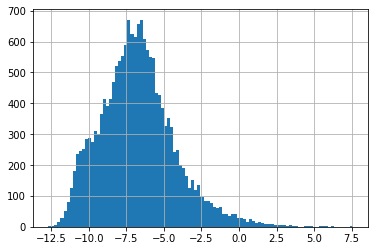

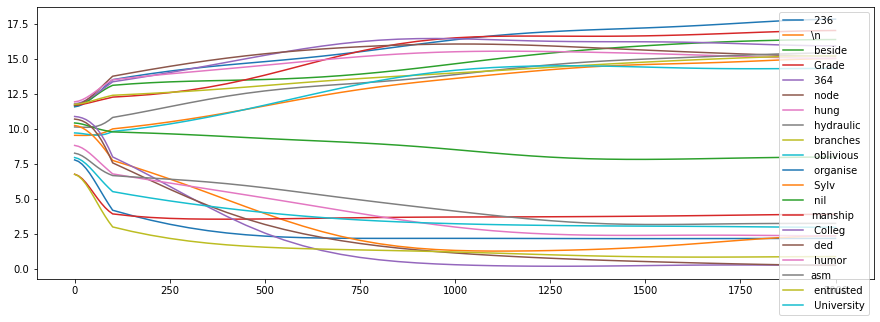

In [57]:
top_n, bottom_n, random_n = compare_checkpoints(checkpoint_numbers, 0, 2000, plot_top=10, plot_random=10, return_n=20)
for name, tokens in zip(["Most Increased", "Most Decreased", "Random"], [top_n, bottom_n, random_n]):
  print(name)
  pprint(tokens)